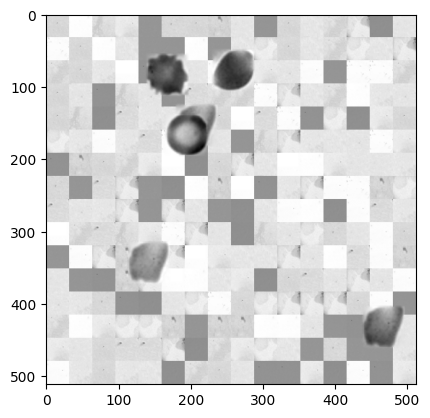

In [134]:
import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
import time
from skimage.metrics import structural_similarity, mean_squared_error
cells_path = 'cl'
background_path = 'bg'
for filename in os.listdir(background_path):
    img=Image.open('bg/' + filename)
    rimg = img.resize((32,32))
    rimg.save('bg/' + filename)
for filename in os.listdir(cells_path):
    img=Image.open('cl/' + filename)
    rimg = img.resize((64,64))
    rimg.save('cl/' + filename)
import cv2
import numpy as np
import random
import os
from glob import glob
import matplotlib.pyplot as plt

def bg_create():
    bg = np.zeros((512,512,3), dtype=np.uint8)
    patch = glob(os.path.join('bg/',"*.png"))
    for i in range(512//32):
        for j in range(512//32):
            p = cv2.imread(random.choice(patch),cv2.IMREAD_GRAYSCALE)
            p = cv2.cvtColor(p, cv2.COLOR_GRAY2BGR)
            bg[i*32:(i+1)*32,j*32:(j+1)*32] = p
    return bg
def cell_create(bg):
    cells = glob(os.path.join('cl/',"*.png"))
    cell = cv2.imread(random.choice(cells),cv2.IMREAD_GRAYSCALE)
    cell = cv2.cvtColor(cell, cv2.COLOR_GRAY2BGR)
    mask = 255 * np.ones(cell.shape, dtype=np.uint8)
    place = (random.randint(0, 512 - 64) + 64 // 2, random.randint(0, 512 - 64) + 64 // 2)
    img = cv2.seamlessClone(cell,bg,mask,place,cv2.NORMAL_CLONE)
    return img
def gauss(img):
    mean = 0
    stddev = 100
    noise_gauss = np.zeros(img.shape, np.uint8)
    cv2.randn(noise_gauss, mean, stddev)
    img = cv2.add(img,noise_gauss)
    return img
def const(img):
    img = cv2.add(img, 10)
    return img
def generate():
    while 1:
        img = bg_create()
        for i in range(random.randint(1,10)):
            img = cell_create(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gs = gauss(img)
        ct = const(img)
        yield img, gs, ct
gen = generate() 
img, gs, ct = next(gen)
plt.imshow(img, cmap = 'gray')

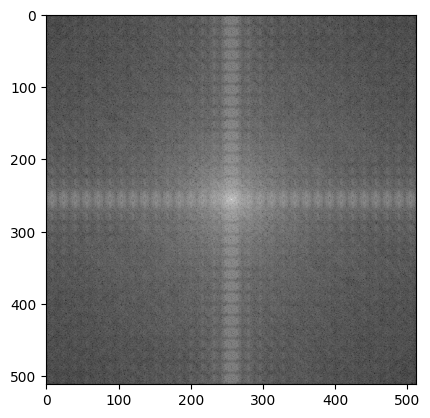

In [135]:
fourier = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
fourier_shift = np.fft.fftshift(fourier)
magnitude = 20*np.log(cv2.magnitude(fourier_shift[:,:,0],fourier_shift[:,:,1]))
magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
plt.imshow(magnitude, cmap = 'gray')


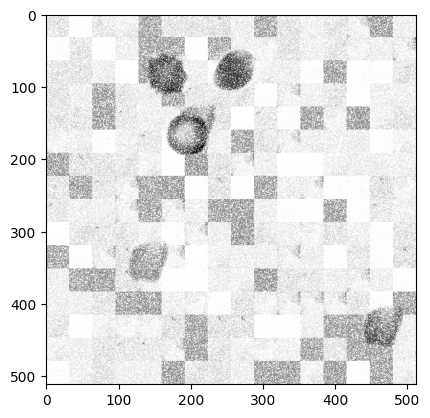

In [136]:
img_gauss = gauss(img)
plt.imshow(img_gauss, cmap = 'gray')

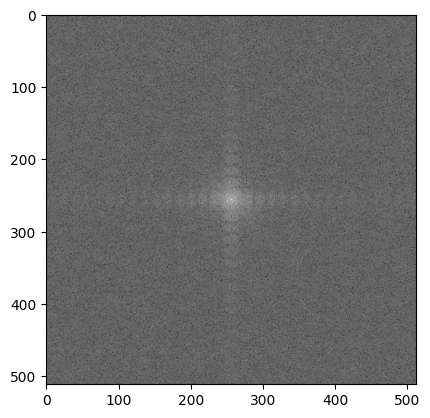

In [137]:
fourier = f = np.fft.fft2(img_gauss)
fourier_shift = np.fft.fftshift(fourier)
magnitude = 20 * np.log(np.abs(fourier_shift))
plt.imshow(magnitude, cmap = 'gray')

In [410]:
rows, cols = img_gauss.shape
crow, ccol = rows // 2, cols // 2
x, y = np.ogrid[:rows, :cols]
D = np.sqrt((x - ccol)**2 + (y - crow)**2);
H = 1/(1 + (D/20)**(2**2));
mask = H
fshift = fourier_shift * mask
magnitude = 20 * np.log(np.abs(fshift))
magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

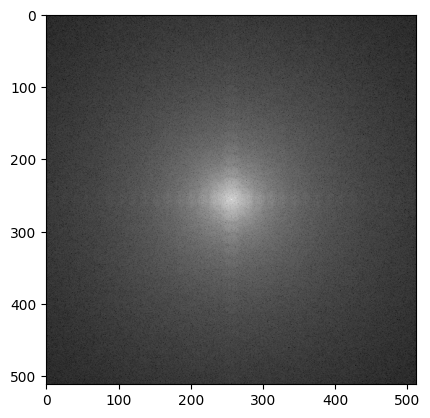

In [411]:
plt.imshow(magnitude, cmap = 'gray')

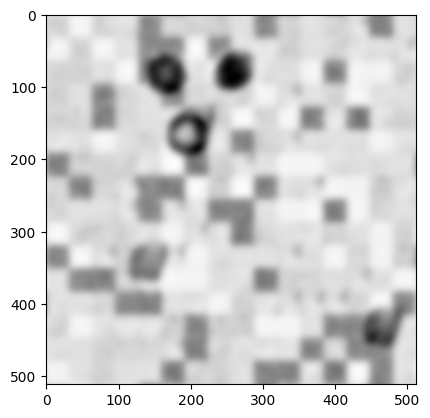

In [412]:
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
img_back = (img_back - img_back.min()) / (img_back.max() - img_back.min())  
img_back = np.uint8(img_back * 255) 
plt.imshow(img_back, cmap = 'gray')

In [413]:
mse = mean_squared_error(img, img_back)
(ssim, diff) = structural_similarity(img,  img_back, full=True)
print(f"MSE = {mse}, SSIM = {ssim}")

MSE = 306.37492752075195, SSIM = 0.7200080557204164


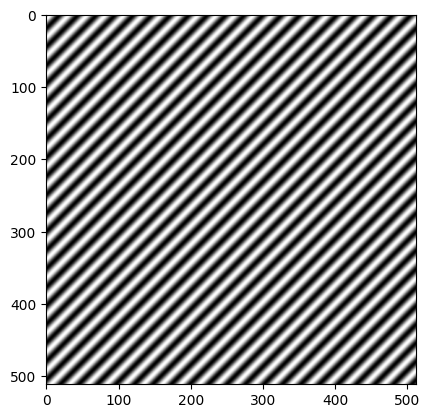

In [276]:
image_p = np.zeros_like(img, dtype=np.float32)
x = np.arange(0, img.shape[1])
y = np.arange(0, img.shape[0])
xx, yy = np.meshgrid(x, y)
period = 30 * np.sin(np.pi * 40 * xx / img.shape[1] + np.pi * 40 * yy / img.shape[0])
plt.imshow(period, cmap = 'gray')

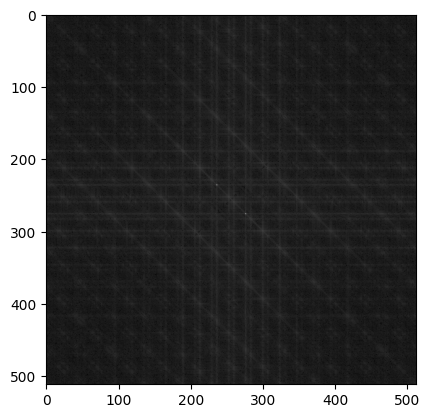

In [277]:
fft_noise = np.fft.fft2(period)
fft_shift = np.fft.fftshift(fft_noise)
magnitude_spectrum = 20 * np.log(np.abs(fft_shift))
plt.imshow(magnitude_spectrum, cmap = 'gray')

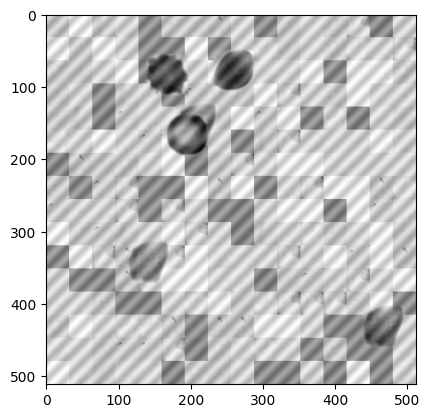

In [278]:
image_p[:, :] = img[:, :] + period
plt.imshow(image_p, cmap = 'gray')

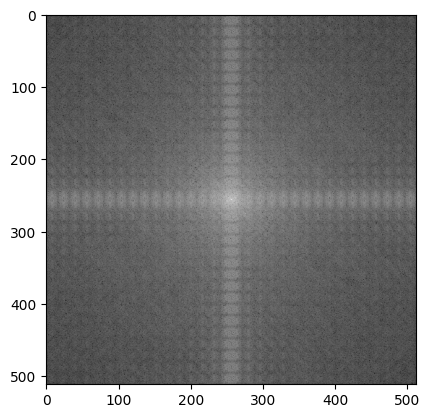

In [279]:
fft_noise = np.fft.fft2(image_p)
fft_shift = np.fft.fftshift(fft_noise)
magnitude_spectrum = 20 * np.log(np.abs(fft_shift))
plt.imshow(magnitude_spectrum, cmap = 'gray')

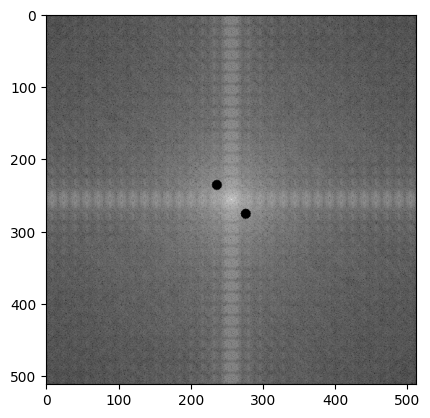

In [300]:
rows, cols = image_p.shape
crow, ccol = rows // 2, cols // 2
mask = np.ones((rows, cols), np.uint8)
radius = 7

cv2.circle(mask, (ccol + (-1)*20, crow + (-1)*20), radius, 0, -1)
cv2.circle(mask, (ccol + 20, crow  + 20), radius, 0, -1)
fshift = fft_shift * mask
magnitude_spectrum = 20 * np.log(np.abs(fshift)+1)
plt.imshow(magnitude_spectrum, cmap = 'gray')

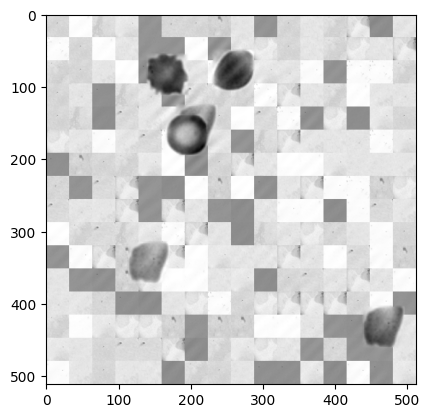

In [301]:
restored_image = np.zeros_like(image_p, dtype=np.float32)
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
restored_image[:, :] = np.abs(img_back)
restored_image = np.clip(restored_image, 0, 255).astype(np.uint8)
plt.imshow(restored_image, cmap = 'gray')

In [302]:
mse = mean_squared_error(img, restored_image)
(ssim, diff) = structural_similarity(img,  restored_image, full=True)
print(f"MSE = {mse}, SSIM = {ssim}")

MSE = 5.435768127441406, SSIM = 0.9843888228501001
